In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

#from __future__ import division

In [2]:
data = pd.read_csv("../data/data_short.csv")
data_swiss = pd.read_csv("../data/DHM25_Alt_slope_Naspect_MODIS_250_clean.csv")
#data = pd.read_csv("../data/data_mock.csv")

In [3]:
data2 = data_swiss.loc[:,['comp', 'LCrich', "N", "E", 'W_w', 'V_w', 'P_w', 'U_w', 'G_w', 'A_w', 'M_w', 'F_w']]
data2 = data2.reset_index(drop=True)

Optimize data types.
tip from https://www.dataquest.io/blog/pandas-big-data/


In [4]:
def mem_optimize(frame):
    # ints
    ints = frame.select_dtypes(include=['int'])
    converted_ints = ints.apply(pd.to_numeric, downcast='unsigned')

    # floats
    floats = frame.select_dtypes(include=["float"])
    converted_floats = floats.apply(pd.to_numeric, downcast='float')


    print("Before: {} MB".format(frame.memory_usage().sum()/1024**2 ))

    # replace
    frame[converted_ints.columns] = converted_ints
    frame[converted_floats.columns] = converted_floats

    print("After: {} MB".format(frame.memory_usage().sum()/1024**2 ))
    
    return frame

data = mem_optimize(data)
data2 = mem_optimize(data2)

Before: 3.2803878784179688 MB
After: 1.5639457702636719 MB
Before: 70.24409484863281 MB
After: 35.85379409790039 MB


Now lets add a column, which counts the number of different covertypes.

In [5]:
# set a new column which holds the number of covertypes in that pixel

comp = data["comp"]
data["covertypeCount"] = comp.apply(lambda x: len(x))

comp = data_swiss["comp"]
data_swiss["covertypeCount"] = data_swiss["comp"].apply(lambda x: x.count("|")+1)
data2["covertypeCount"] = data_swiss["covertypeCount"]

In [6]:
onetype_frame = data[data["covertypeCount"] == 1]
twotypes_frame = data[data["covertypeCount"] == 2]
threetypes_frame = data[data["covertypeCount"] == 3]
fourtypes_frame = data[data["covertypeCount"] == 4]
fivetypes_frame = data[data["covertypeCount"] == 5]

onetype_frame_swiss = data2[data2["covertypeCount"] == 1]
twotypes_frame_swiss = data2[data2["covertypeCount"] == 2]
threetypes_frame_swiss = data2[data2["covertypeCount"] == 3]
fourtypes_frame_swiss = data2[data2["covertypeCount"] == 4]
fivetypes_frame_swiss = data2[data2["covertypeCount"] == 5]

# change to ..
test_frame = twotypes_frame_swiss

Analyse landcomposition fractions..

In [7]:
land_type_fractions1 = ['fracA', 'fracH', 'fracB', 'fracF', 'fracG', 'fracS', 'fracW']
land_type_fractions2 = ['W_w', 'V_w', 'P_w', 'U_w', 'G_w', 'A_w', 'M_w', 'F_w']

# change to ..
land_type_fractions = land_type_fractions2


def landtypes_info(frame):
    return frame[land_type_fractions].sum()

print(landtypes_info(test_frame))

W_w     2881.376709
V_w    29536.099609
P_w    22114.177734
U_w    13789.071289
G_w      727.351196
A_w    26885.148438
M_w    77744.523438
F_w    94785.968750
dtype: float32


Looking at the sums above, we maybe want to exclude a type.. 

In [8]:
def drop_and_copy(frame, to_drop):
    """drop all rows with non zero entries in frac{to_drop}
        creates a copy of the data
    """
    mask = np.full(len(frame), True)
    for d in to_drop:
        mask &= frame[d] == 0
    
    print("Dropping {} of {} datapoints.".format(len(frame) - np.count_nonzero(mask), len(frame)))
    
    # copy data to a new dataframe
    return frame[mask].reset_index(drop=True)


#to_drop = ["fracG", "fracB", "fracW"]
to_drop = []
test_frame = drop_and_copy(test_frame, to_drop=to_drop)

Dropping 0 of 268777 datapoints.


Try to find the "good" subset..

In [9]:
def deviation(frame, mask):
    sums = frame[mask].loc[:,land_type_fractions].sum()
    avg = sums.mean()
    dev = sums - avg
    return dev

def error_function(frame, mask_in):
    dev = deviation(frame, mask_in).values
    ltf = frame.loc[:,land_type_fractions].values

    # do scalar product of every point in a with the deviation
    # this should be a measure of how good the point is to the frame
    error = np.einsum("i,ji", dev, ltf)
    return error

def optimize(frame, start_mask, n_steps=200):
    """start_mask defines the starting subset
        in: the points in the subset
        out: the points outside the subset
    """
    mask_in = start_mask
    mask_out = np.logical_not(mask_in)

    # analoge to tempertaure in simulated annealing
    # start with maximum amount of swaps divided by 2
    start = len(frame[start_mask])//2
    end = 1    
    swaps = list(np.linspace(start, end, n_steps)) #+ [5,5,5,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1]
    
    for i, n_swaps in enumerate(swaps):

        n_swaps = int(n_swaps)
        
        # set the error value for each pixel ... 
        frame.loc[:,"_error"] = error_function(frame, mask_in)

        
        # find the indices to swap
        max_indices_in = frame[mask_in].nlargest(n_swaps, "_error").index
        min_indices_out = frame[mask_out].nsmallest(n_swaps, "_error").index

        # swap: update the mask
        mask_in[max_indices_in] = False
        mask_in[min_indices_out] = True

        mask_out = np.logical_not(mask_in)
        
        print("round {}: swapped {} entries.".format(i, n_swaps))
    
    print("done.")
    frame.drop(columns = ["_error"])
    return mask_in
    

    
in_the_subset = 0.08

random_mask = np.random.choice([True, False], size=len(test_frame), p=[in_the_subset, 1.0-in_the_subset])

updated_mask = optimize(test_frame, random_mask.copy(), n_steps=150)

round 0: swapped 10769 entries.
round 1: swapped 10696 entries.
round 2: swapped 10624 entries.
round 3: swapped 10552 entries.
round 4: swapped 10479 entries.
round 5: swapped 10407 entries.
round 6: swapped 10335 entries.
round 7: swapped 10263 entries.
round 8: swapped 10190 entries.
round 9: swapped 10118 entries.
round 10: swapped 10046 entries.
round 11: swapped 9974 entries.
round 12: swapped 9901 entries.
round 13: swapped 9829 entries.
round 14: swapped 9757 entries.
round 15: swapped 9684 entries.
round 16: swapped 9612 entries.
round 17: swapped 9540 entries.
round 18: swapped 9468 entries.
round 19: swapped 9395 entries.
round 20: swapped 9323 entries.
round 21: swapped 9251 entries.
round 22: swapped 9179 entries.
round 23: swapped 9106 entries.
round 24: swapped 9034 entries.
round 25: swapped 8962 entries.
round 26: swapped 8890 entries.
round 27: swapped 8817 entries.
round 28: swapped 8745 entries.
round 29: swapped 8673 entries.
round 30: swapped 8600 entries.
round 3

In [10]:
landtypes_info(test_frame)

W_w     2881.376709
V_w    29536.099609
P_w    22114.177734
U_w    13789.071289
G_w      727.351196
A_w    26885.148438
M_w    77744.523438
F_w    94785.968750
dtype: float32

In [11]:
optimized_subset = test_frame[updated_mask]
landtypes_info(optimized_subset)

W_w    2808.645508
V_w    2963.162109
P_w    2962.389648
U_w    2976.259521
G_w     724.143127
A_w    2961.549316
M_w    2931.622559
F_w    2953.983887
dtype: float32

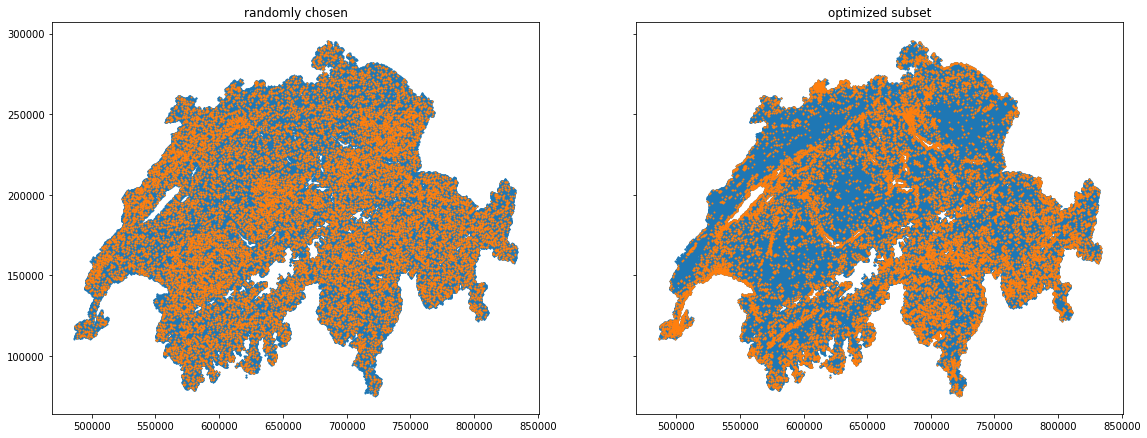

In [12]:
x = test_frame.loc[:,"E"]
y = test_frame.loc[:,"N"]

x_rand = test_frame[random_mask].loc[:,"E"]
y_rand = test_frame[random_mask].loc[:,"N"]

x_in = test_frame[updated_mask].loc[:,"E"]
y_in = test_frame[updated_mask].loc[:,"N"]

plt.figure(figsize=[6.4*1.5*2, 4.8*1.5])
ax1 = plt.subplot(121)
plt.title("randomly chosen")
plt.scatter(x, y, s=1)
plt.scatter(x_rand, y_rand, s=1)

ax2 = plt.subplot(122, sharey=ax1)
plt.title("optimized subset")
plt.scatter(x, y, s=1)
plt.scatter(x_in, y_in, s=1)
plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()

In [ ]:
plt.figure(figsize=[6.4*2.5, 4.8*2.5])
plt.title("optimized subset")
plt.scatter(x, y, s=1)
plt.scatter(x_rand, y_rand, s=1)
plt.show()

In [ ]:
plt.figure(figsize=[6.4*2.5, 4.8*2.5])
plt.title("optimized subset")
plt.scatter(x, y, s=1)
plt.scatter(x_in, y_in, s=1)
plt.show()

In [ ]:
sns.jointplot(x=x_in, y=y_in, kind="kde")

In [ ]:
sns.jointplot(x=x_rand, y=y_rand, kind="kde")